## Information Retrieval from Documents


## Objective

With the rise of Generative AI models these days, there has been an increase in the demand for document retrieval systems.

The objective of our system is to design and implement a supervised learning document retrieval system that efficiently finds the relevant information from the documents in response to user queries while ensuring the retrieval system provides results in a timely manner.

The system aims to capture the semantic context of the user’s input and retrieve documents that are not only keyword-matching but also contextually relevant.


## Use Case

We will be designing a General Purpose Document Retrieval System which can benefit a wide range of users.

- Researchers and Academicians ( research papers, scholarly documents )
- Professionals ( Be it legal, medical, finance or corporate sectors )
- Students and Educators

Moreover, this also aims for the individuals seeking information on various topics like healthcare, technology, cooking, or any domain can retrieve relevant documents, guides, and articles improving their knowledge and skills.


## Data

As a baseline, we want our dataset to be generic and contains a vast spectrum of knowledge so that the system works well with wide range of users.

- We will be using Simple English Wikipedia Dataset from Published by SBert - https://www.sbert.net/, https://sbert.net/datasets

- Compared to the full English wikipedia, it has smaller number of articles and the amount of texts.



In [ ]:
!pip install sentence_transformers

## Preparing the Dataset

We will load json line file and convert it into a data frame.

In [3]:
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.metrics import jaccard_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
file_path = '/content/drive/MyDrive/datasets/simplewiki-2020-11-01.jsonl'

def parse_json(s):
  try:
      return json.loads(s)
  except:
      return None

datapoints = []
with open(file_path) as f:
    lines = f.read().splitlines()

    for line in lines:
      data = parse_json(line.strip())

      # if the JSON entry is corrupted, we will drop it
      if data == None:
        continue

      for paragraph in data['paragraphs']:
          # we encode the passages as {title, text}
          datapoints.append({
              'title': data['title'],
              'paragraph':  paragraph
          })

df = pd.DataFrame(datapoints)

## Data Cleaning

In [5]:
df.head(10)

,title,paragraph
0,Ted Cassidy,"Ted Cassidy (July 31, 1932 - January 16, 1979)..."
1,Aileen Wuornos,Aileen Carol Wuornos Pralle (born Aileen Carol...
2,Aileen Wuornos,Wuornos was diagnosed with antisocial personal...
3,Aileen Wuornos,"The movie, ""Monster"" is about her life. Two do..."
4,Aileen Wuornos,Wuornos was born Aileen Carol Pittman in Roche...
5,Crater,A crater is a round dent on a planet. They are...
6,Store,Store has several meanings:
7,Chinese New Year,"Chinese New Year, known in China as the Spring..."
8,Chinese New Year,The Chinese New Year is of the most important ...
9,Chinese New Year,Chinese New Year used to last 15 days until th...


In [6]:
print(f'total number of estimated samples {df.shape[0]}\ntotal number of features {df.shape[1]}')

total number of estimated samples 509663
total number of features 2


The dataset contains two features that we built up earlier and 500K samples which is a pretty good amount of data to demonstrate the document retrieval system.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509663 entries, 0 to 509662
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      509663 non-null  object
 1   paragraph  509663 non-null  object
dtypes: object(2)
memory usage: 7.8+ MB


### Handling missing values

#### Drop NA

In [8]:
total_values = df.size
missing_values = df.isna().sum()

missing_percentage = (missing_values / total_values) * 100

print("Missing values (na) count:")
print(missing_values)

print("\nPercentage of missing values (na):")
print(missing_percentage)

Missing values (na) count:
title        0
paragraph    0
dtype: int64

Percentage of missing values (na):
title        0.0
paragraph    0.0
dtype: float64


In [9]:
df = df.dropna()

#### Drop value with empty strings

We don't have much features. But it is important that our title and paragraph are not empty.

In [10]:
# create a boolean mask for non-empty strings
non_empty_mask = (df['title'] != '') & (df['paragraph'] != '')

# filter the DataFrame using the mask
df = df[non_empty_mask]

#### Building a new Feature

We will build a new feature to use across the EDA process.

In [11]:
df['full_text'] = df['title'] + '\n' + df['paragraph']

## Exploratory Data Analysis (EDA)

### Document Length Analysis

We will first analyze the distribution of the token count of each passage title + paragraph.

In [12]:
def tokenize_text(text):
    """
    Tokenizes input text using NLTK's word_tokenize function.

    Parameters:
    - text (str): The text to tokenize.

    Returns:
    - list of str: The tokenized text.
    """

    # tokenize text
    tokens = word_tokenize(text)

    return tokens

In [13]:
df['token_count'] = df['full_text'].apply(lambda x: len(x.split()))

In [14]:
mean_length = df['token_count'].mean()
median_length = df['token_count'].median()
mode_length = df['token_count'].mode()[0]  # mode() returns a Series, get the first element
min_length = df['token_count'].min()
max_length = df['token_count'].max()

print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length}")
print(f"Mode length: {mode_length}")
print(f"Min length: {min_length}")
print(f"Max length: {max_length}")

Mean length: 44.79
Median length: 37.0
Mode length: 21
Min length: 2
Max length: 1188


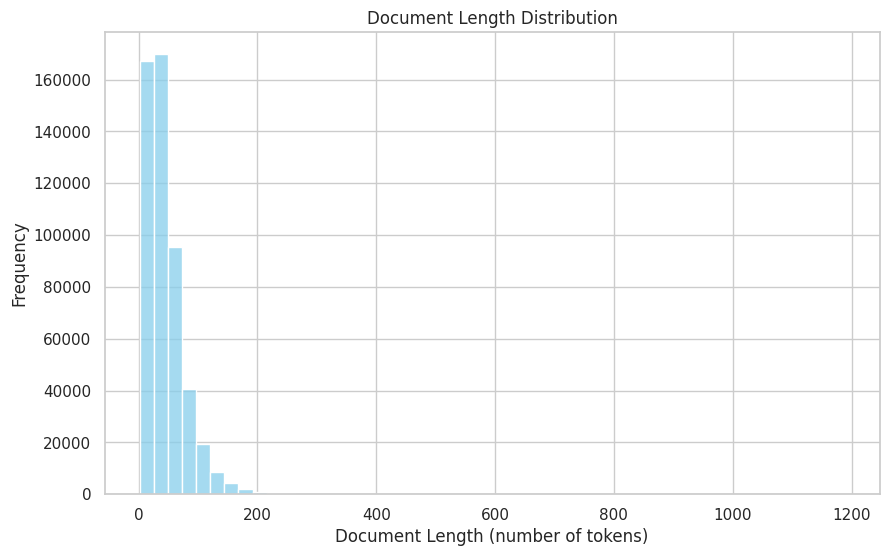

In [15]:
sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['token_count'], bins=50, kde=False, color='skyblue')
plt.title('Document Length Distribution')
plt.xlabel('Document Length (number of tokens)')
plt.ylabel('Frequency')
plt.show()

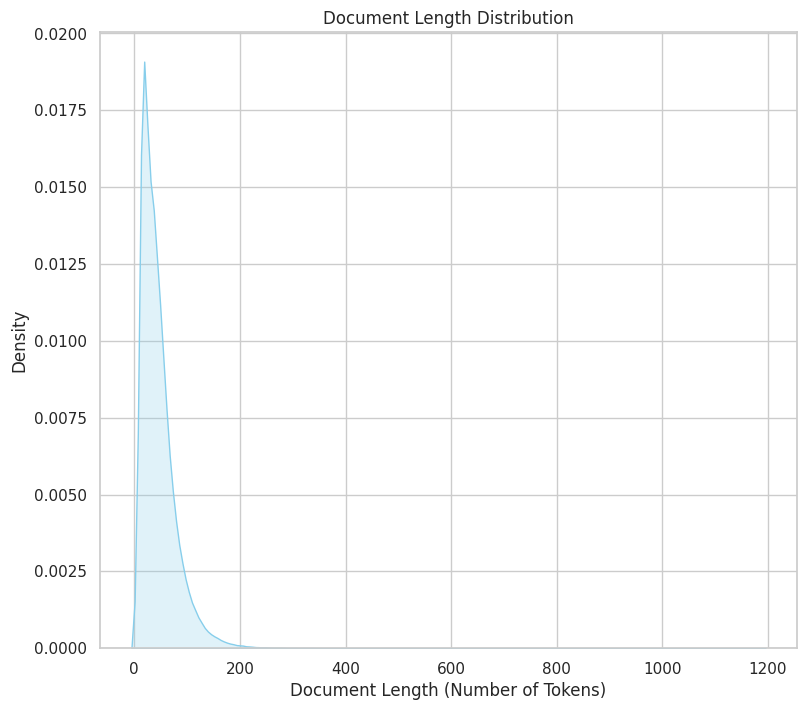

In [16]:
# KDE plot
plt.figure(figsize=(9, 8))
sns.kdeplot(df['token_count'], color='skyblue', fill=True)
plt.title('Document Length Distribution')
plt.xlabel('Document Length (Number of Tokens)')
plt.ylabel('Density')
plt.show()

From our Histogram and KDE diagrams, we find out that

- Histogram: Shows a right-skewed distribution with most Wikipedia documents having a low token count.

- KDE Peak: Indicates the most common document length, reaffirming that most documents are short.

- Right Skew: Both plots emphasize that longer documents are rare, with a majority being concise.

## Model Building and Training

Our strategy is as follows

- First, we will vectorize all of our text data from wikipedia corpus dataset using the `ms macro` family embeddings model

- Then we will build a kNN model on the resulting numerical dataset.


The reason we choose `ms macro` embedding model is

1. Embeddings model can capture the context of the text data and also sematic meaning which is one of the core feature of our system.

2. There are two categories in embeddings models. `symmetric` and `asymmetric` models.

`symmetric` models tends to work better with shorter length texts like a single sentence.

In our case, we have longer context which is a chunk of article. Therefore, `asymmetric` model will works better.

We call also take a reference here - https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search

### Embeddings

In [17]:
import torch
from sentence_transformers import SentenceTransformer, util

In [18]:
DEVICE = "cpu"

if torch.cuda.is_available():
    DEVICE = "cuda"


if torch.backends.mps.is_available():
    DEVICE = "mps"

DEVICE

'cuda'

In [19]:
embedder = SentenceTransformer(
    'sentence-transformers/msmarco-distilbert-base-v4', device=DEVICE)

In [20]:
def generate_embeddings(texts):
  return np.array(embedder.encode(texts, normalize_embeddings=True))

# single text
def generate_embedding(text):
  return np.array(embedder.encode([text], normalize_embeddings=True)[0])

### Model Training

We will use `kNN` to perform the nearest neighbor search.

#### Distances

We will experiment with a two different methods for calculating distances and different numbers of neighbors.

1. euclidean distance
2. cosine distance

#### Generate Embeddings

First we will transform the raw texts into a 2 dimensional vector and save to a `npy` file for easy access to use later.

In [21]:
# ms macro produces 768 long vector
embeddings = np.empty((0, 768))

# support batching for efficient processing
batch_size = 5000
num_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)

for i in range(num_batches):
    print(f'Procesing batch {i}')

    batch_data = df.iloc[i*batch_size : (i+1)*batch_size]['full_text'].tolist()

    processed_batch = generate_embeddings(batch_data)

    embeddings = np.concatenate([embeddings, processed_batch], axis=0)

Procesing batch 0
Procesing batch 1
Procesing batch 2
Procesing batch 3
Procesing batch 4
Procesing batch 5
Procesing batch 6
Procesing batch 7
Procesing batch 8
Procesing batch 9
Procesing batch 10
Procesing batch 11
Procesing batch 12
Procesing batch 13
Procesing batch 14
Procesing batch 15
Procesing batch 16
Procesing batch 17
Procesing batch 18
Procesing batch 19
Procesing batch 20
Procesing batch 21
Procesing batch 22
Procesing batch 23
Procesing batch 24
Procesing batch 25
Procesing batch 26
Procesing batch 27
Procesing batch 28
Procesing batch 29
Procesing batch 30
Procesing batch 31
Procesing batch 32
Procesing batch 33
Procesing batch 34
Procesing batch 35
Procesing batch 36
Procesing batch 37
Procesing batch 38
Procesing batch 39
Procesing batch 40
Procesing batch 41
Procesing batch 42
Procesing batch 43
Procesing batch 44
Procesing batch 45
Procesing batch 46
Procesing batch 47
Procesing batch 48
Procesing batch 49
Procesing batch 50
Procesing batch 51
Procesing batch 52
Pro

In [22]:
np.save('embeddings.npy', embeddings)

In [23]:
# embeddings = np.load('embeddings.npy', allow_pickle=True)

In [24]:
print(f'Total number of datapoints: {len(embeddings)}')
print(f'Dimension of each embedding vector: {len(embeddings[0])}')

print(type(embeddings[0]))
print(embeddings.shape)
print(type(embeddings))

Total number of datapoints: 509663
Dimension of each embedding vector: 768
<class 'numpy.ndarray'>
(509663, 768)
<class 'numpy.ndarray'>


#### K Nearest Neighbors - Euclidean Distance (L2)

In [25]:
from sklearn.neighbors import NearestNeighbors

knn_l2 = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
knn_l2.fit(embeddings)

NearestNeighbors(metric='euclidean')

#### K Nearest Neighbors - Manhattan Distance

In [26]:
knn_manhattan = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='manhattan')
knn_manhattan.fit(embeddings)

NearestNeighbors(metric='manhattan')

#### K Nearest Neighbors - Cosine Distance

In [27]:
knn_cosine = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
knn_cosine.fit(embeddings)

NearestNeighbors(metric='cosine')

## Modal Evaluation

As our kNN model is not just simply classification or regression task, the evaluation is not straight forward.

Which means we cannot directly split the data set into train and test datasets and test the resulting model against the test dataset.

We will approach the evaluation with following strategies.

1. Prepare a set of test queries which different topics.
2. Do the kNN search on query embeddings against the in memoery kNN model that is already fit.
3. We use our judement to see if the results are relavant.
4. Compare the results from different model using the metrics such as correlation matrix.

### Test Queries

In [29]:
test_queries_file = 'test_queries.jsonl'
test_df = pd.read_json(test_queries_file, lines=True)

In [30]:
test_df.head()

,topic,query
0,Science & Technology,Explain the theory of relativity.
1,Science & Technology,What is quantum computing?
2,Science & Technology,How does photosynthesis work in plants?
3,History & Geography,Describe the events of World War II.
4,History & Geography,What is the significance of the Silk Road?


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   36 non-null     object
 1   query   36 non-null     object
dtypes: object(2)
memory usage: 704.0+ bytes


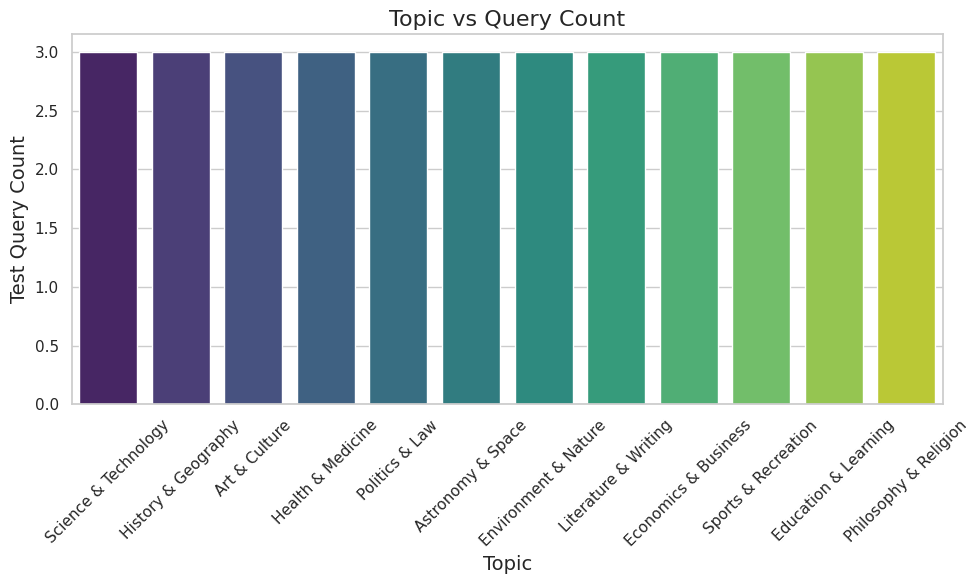

In [32]:
# Count the occurrence of each unique topic
topic_counts = test_df['topic'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")

# Title and labels
plt.title('Topic vs Query Count', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Test Query Count', fontsize=14)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I have prepared the test queries dataset to evaluate our models.

As we can see in the above bar plot, it includes a wide range of topics and each topics has 3 queries.

In [33]:
test_df['embeddings'] = test_df['query'].apply(generate_embedding)

In [34]:
test_df.head()

,topic,query,embeddings
0,Science & Technology,Explain the theory of relativity.,"[-0.03815084, 0.074825004, 0.009415368, -0.001..."
1,Science & Technology,What is quantum computing?,"[-0.042272806, -0.011318804, -0.026727837, -0...."
2,Science & Technology,How does photosynthesis work in plants?,"[0.0115440525, 0.028786829, 0.022951113, 0.007..."
3,History & Geography,Describe the events of World War II.,"[-0.015025223, -0.011712082, -0.066145435, 0.0..."
4,History & Geography,What is the significance of the Silk Road?,"[-0.03404801, 0.041059125, -0.08713838, -0.020..."


### Predictions

For each test query, we will run the prediction with three different knn models and take the resulting indices of the data points.

In [35]:
results = {}

for index, row in test_df.iterrows():
  query_text = row['query']
  query_embedding = row['embeddings']

  predictions_cosine_indices = knn_cosine.kneighbors([query_embedding], return_distance=False)
  predictions_euclidean_indices = knn_l2.kneighbors([query_embedding], return_distance=False)
  predictions_manhattan_indices = knn_manhattan.kneighbors([query_embedding], return_distance=False)

  results[query_text] = {
      'cosine': predictions_cosine_indices,
      'l2': predictions_euclidean_indices,
      'manhattan': predictions_manhattan_indices
  }

In [36]:
# Initialize a DataFrame to store the similarities
similarities = pd.DataFrame(index=results.keys(), columns=['cosine_l2', 'cosine_manhattan', 'l2_manhattan'])

# Calculate the pairwise similarities
for query, preds in results.items():

    # reshaping
    pred_cosine = preds['cosine'][0]
    pred_l2 = preds['l2'][0]
    pred_manhattan = preds['manhattan'][0]

    similarities.loc[query, 'cosine_l2'] = jaccard_score(pred_cosine, pred_l2, average='micro')
    similarities.loc[query, 'cosine_manhattan'] = jaccard_score(pred_cosine, pred_manhattan, average='micro')
    similarities.loc[query, 'l2_manhattan'] = jaccard_score(pred_l2, pred_manhattan, average='micro')

similarities.head()

,cosine_l2,cosine_manhattan,l2_manhattan
Explain the theory of relativity.,1.0,0.428571,0.428571
What is quantum computing?,1.0,1.0,1.0
How does photosynthesis work in plants?,1.0,1.0,1.0
Describe the events of World War II.,1.0,0.25,0.25
What is the significance of the Silk Road?,1.0,0.428571,0.428571


We have run the predictions and dropped the similarity measures into a data frame.

Indices are a set of unique indices of the data points. So, to compare these kind of set, jaccard score will be more convenient.

Now,let's visualize using some relevant diagrams.

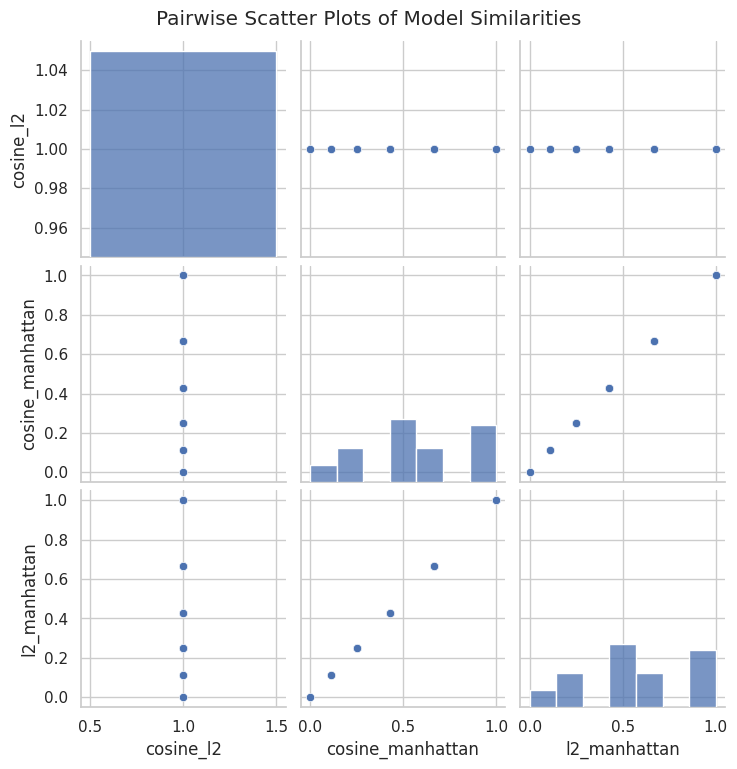

In [43]:
sns.pairplot(similarities)
plt.suptitle('Pairwise Scatter Plots of Model Similarities', y=1.02)
plt.show()

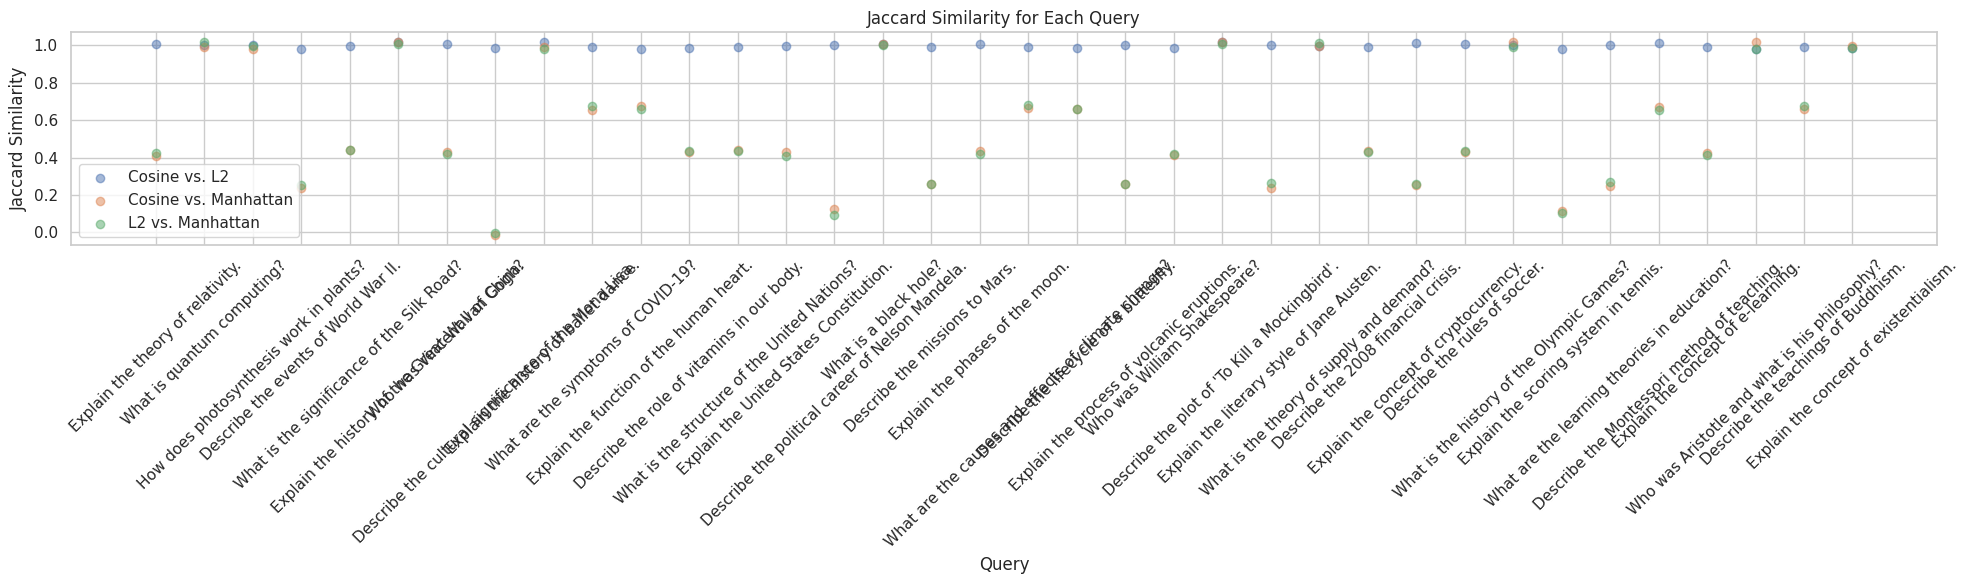

In [49]:
plt.figure(figsize=(20, 6))

# Adding jitter and using alpha
jitter_amount = 0.02
similarities_jittered = similarities.copy()
similarities_jittered += np.random.uniform(-jitter_amount, jitter_amount, size=similarities.shape)

plt.scatter(similarities_jittered.index, similarities_jittered['cosine_l2'], label='Cosine vs. L2', alpha=0.5)
plt.scatter(similarities_jittered.index, similarities_jittered['cosine_manhattan'], label='Cosine vs. Manhattan', alpha=0.5)
plt.scatter(similarities_jittered.index, similarities_jittered['l2_manhattan'], label='L2 vs. Manhattan', alpha=0.5)

plt.xlabel('Query')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Similarity for Each Query')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Findings

Based on the above scatter plot for predictions similarity, we can conclude as following

- The models with Consine distance and Euclidean distance ( L2 ) produce idential results give our test data set.

- Other two pairs, `Cosine vs. Manhattan` and `L2 vs. Manhattan` produce different results. The similarity distribution between different methods is not linear. There is curve.

- In both of these two, Manhattan is the common one. This indicates that the using the Manhattan distance metrics might not be a good choice.
Also our data set is not based on the grid.

So, I assume that cosine and L2 distance metrics are a good choice for our model.

#### Relevancy Check

As a final check, we will use our own judegement to see if the results are really relevant.

For simplicity, I will use results from cosine distance.

In [61]:
for query, preds in results.items():
  print('Query: ' + query)
  print('Result: ')

  for i, idx in enumerate(preds['cosine'][0]):
    print(df.iloc[idx]['paragraph'])

  print('\n\n')

Query: Explain the theory of relativity.
Result: 
The theory aims to solve problems which could not be solved by classical physics, or by 19th century physics. Certain observations, like the orbit of Mercury or the way light from distant sources bends as it passes a star, cannot be explained by the physics of 1900. Einstein set out to revise the basic ideas of physics. His work was done in two stages, and each stage has a separate page on this wiki.
The General Theory of Relativity was published in 1915, ten years after the special theory of relativity was created. Einstein's general theory of relativity uses the idea of spacetime. Spacetime is the fact that we have a four-dimensional universe, having three spatial (space) dimensions and one temporal (time) dimension. Any physical event happens at some place inside these three space dimensions, and at some moment in time. According to the general theory of relativity, any mass causes spacetime to curve, and any other mass follows these

From all these results, we can witness that the results are actually relavant.

## Future Work

We can try with different numbers of neighbors. But this won't improve the performance and quality of the output data as the nature of our dataset is not regression or classification.

If regression or classification, this will indeed useful.

1. We can pre index the kNN model and accept the top K params with allow users to adjust the number of query.

2. Now, we are using simple wikipedia english dataset. We can improve further using full english wikipedia corpus dataset. Which are inherently large in dataset size. But the will definitely beneficials in real world use case.